In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [58]:
df = pd.read_csv("Electric_Production.csv")
df = df.set_index("DATE")
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')
# df = df.groupby(pd.Grouper(freq='m')).mean()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


,Value
DATE,
1985-01-01,72.5052
1985-01-02,70.6720
1985-01-03,62.4502
1985-01-04,57.4714
1985-01-05,55.3151


Number of measurements: 397


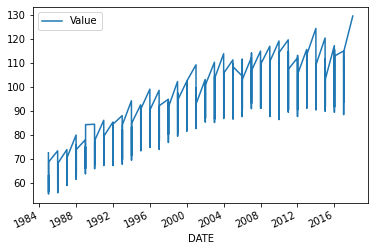

In [59]:
#Ploting temperature in Celsius degrees
print("Number of measurements: "+str(len(df['Value'])))
df.plot(y='Value', rot=25);

In [60]:
dftm = df['Value']
print(dftm)

DATE
1985-01-01     72.5052
1985-01-02     70.6720
1985-01-03     62.4502
1985-01-04     57.4714
1985-01-05     55.3151
                ...   
2017-01-09     98.6154
2017-01-10     93.6137
2017-01-11     97.3359
2017-01-12    114.7212
2018-01-01    129.4048
Name: Value, Length: 397, dtype: float64


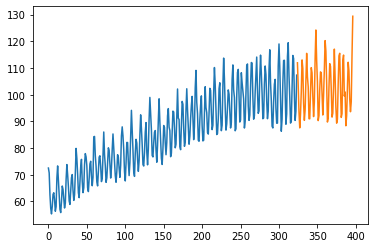

In [61]:
# Spliting the last 2 years for test
train = dftm[:12*27].values
plt.plot(np.arange(len(train)),train)
train = train.reshape((len(train), 1))
test = dftm[12*27:].values
plt.plot(np.arange(len(train), len(train)+len(test)),test)
test = test.reshape((len(test), 1))
#plt.plot(np.arange(len(df3d)),df3d)

In [62]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [63]:
length = 12
generator = TimeseriesGenerator(train,train,length=length, batch_size=1)
validation_generator = TimeseriesGenerator(test,test,length=length, batch_size=1)

In [64]:
print(train[:length+1])

[[72.5052]
 [70.672 ]
 [62.4502]
 [57.4714]
 [55.3151]
 [58.0904]
 [62.6202]
 [63.2485]
 [60.5846]
 [56.3154]
 [58.0005]
 [68.7145]
 [73.3057]]


In [65]:
i=0
for x,y in generator:
    print(x)
    print(y)
    i = i + 1
    if i == 2:
        break

[[[72.5052]
  [70.672 ]
  [62.4502]
  [57.4714]
  [55.3151]
  [58.0904]
  [62.6202]
  [63.2485]
  [60.5846]
  [56.3154]
  [58.0005]
  [68.7145]]]
[[73.3057]]
[[[70.672 ]
  [62.4502]
  [57.4714]
  [55.3151]
  [58.0904]
  [62.6202]
  [63.2485]
  [60.5846]
  [56.3154]
  [58.0005]
  [68.7145]
  [73.3057]]]
[[67.9869]]


# Creating LSTM model


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [67]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(length,1)))
# model.add(GRU(20, activation='relu', return_sequences=True, input_shape=(length,1)))
# model.add(GRU(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [68]:
epochs = 100
early_stop = EarlyStopping(monitor='val_loss',patience=10)
ckpt = ModelCheckpoint('model6.hdf5', save_best_only=True, monitor='val_loss', verbose=1)
history = model.fit_generator(
    generator,
    steps_per_epoch=len(generator),
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, ckpt])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/100
304/312 [============================>.] - ETA: 0s - loss: 7447.6265
Epoch 00001: val_loss improved from inf to 5360.37500, saving model to model6.hdf5
312/312 [==============================] - 3s 6ms/step - loss: 7370.9790 - val_loss: 5360.3750
Epoch 2/100
305/312 [============================>.] - ETA: 0s - loss: 4391.9624
Epoch 00002: val_loss did not improve from 5360.37500
312/312 [==============================] - 2s 6ms/step - loss: 4426.0693 - val_loss: 7606.8208
Epoch 3/100
309/312 [============================>.] - ETA: 0s - loss: 2074.6255
Epoch 00003: val_loss improved from 5360.37500 to 644.44391, saving model to model6.hdf5
312/312 [==============================] - 2s 6ms/step - loss: 2056.9805 - val_loss: 644.4439
Epoch 4/100
308/312 [============================>.] - ETA: 0s - loss: 196.6058
Epoch 00004: val_loss improved from 644.44391 to 238.21014, saving model to model6.hdf5
312/312 [==============================] - 2s 6ms/step - loss: 196.5981 - val_l

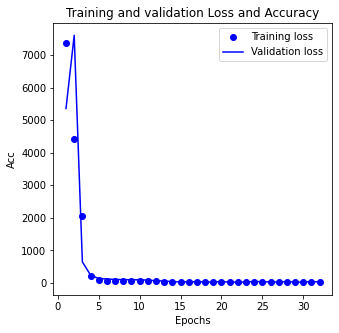

In [69]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(5,5))
#plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Evaluating the Accuracy

In [70]:
# Load the best model
model.load_weights("model6.hdf5")

# Predicting some days ahead.
test_predictions = []
first_eval_batch = train[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))
for i in range(len(test)):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    # store prediction
    test_predictions.append(current_pred)
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
#prediction = scaler.inverse_transform(test_predictions)

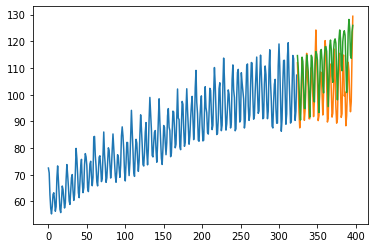

In [71]:
# Comparing test data and predictions
plt.plot(np.arange(len(train)), train)
plt.plot(np.arange(len(train),len(train)+len(test)),test)
plt.plot(np.arange(len(train),len(train)+len(test)),test_predictions)

In [74]:
# Calculating the mean squared error
mse = np.mean(np.square(test[:,0] - np.array(test_predictions)[:,0]), axis=-1)
loss = np.sqrt(mse)
print("mse: "+str(loss))

mse: 11.028026586211753
